In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

# Viral load data fitting

Macaque monkies data from

*Chandrashekar, A., Liu, J., Martinot, A. J., McMahan, K., Mercado, N. B., Peter, L., Tostanoski, L. H., Yu, J., Maliga, Z., Nekorchuk, M., Busman-Sahay, K., Terry, M., Wrijil, L. M., Ducat, S., Martinez, D. R., Atyeo, C., Fischinger, S., Burke, J. S., Slein, M. D., … Barouch, D. H. (2020). SARS-CoV-2 infection protects against rechallenge in rhesus macaques. Science, 817(August), eabc4776. https://doi.org/10.1126/science.abc4776*


## Data set

3 data sets from nasal swab (NS) samples with 10 observations and 3 data sets from 3 data sets from bronchoalveolar lavage (BAL) with 7 observations, each with 3 individuals.

In [4]:
RAWDATA = Dict()
path = "../../data/Chandrashekar2020/"
foreach(filter(x->occursin(".csv", x), readdir(path))) do file
    temp = readdlm(path*file, ',', Float64, '\n', header=true)
    RAWDATA[file[1:end-4]] = DataFrame(temp[1], Symbol.(temp[2][:]))
end
for k in keys(RAWDATA)
    display("Data: "*k)
    display(RAWDATA[k])
end

"Data: Group 3 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,5.57957,6.78347,6.52007,5.68887,5.00241,3.71236,3.99145,1.69897,1.69897
2,1.69897,3.73932,5.05975,2.46123,1.69897,1.69897,1.69897,1.69897,1.69897,1.69897
3,1.69897,3.60011,6.78389,5.70977,6.19306,5.36131,2.80269,1.69897,1.94787,1.69897


"Data: Group 1 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.4688,8.16525,6.23715,5.12414,3.3126,1.69897,1.69897
2,4.14981,5.00692,5.32055,2.65836,1.69897,1.69897,1.69897
3,6.26342,5.88252,3.67602,1.99093,1.69897,1.69897,1.69897


"Data: Group 2 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.8212,6.5641,3.83382,3.22656,2.16679,1.69897,1.69897
2,5.73113,7.31209,4.65007,4.31562,2.06809,2.82957,1.69897
3,8.02753,8.96746,6.95217,5.19312,4.95855,1.69897,1.69897


"Data: Group 2 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,4.6673,6.9958,6.4588,6.55061,5.1867,3.30582,2.85234,1.69897,1.69897
2,1.69897,7.08751,7.09246,5.72399,5.83477,3.66631,3.62261,1.69897,1.69897,1.69897
3,1.69897,6.33338,8.16723,7.13837,5.33877,2.94954,1.69897,1.69897,1.69897,1.69897


"Data: Group 1 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,7.43565,7.85023,6.96461,6.20642,5.21971,4.42147,3.39755,2.65476,1.69897
2,1.69897,6.92311,8.54628,6.57286,6.20234,3.89381,3.59259,2.33387,2.11574,1.69897
3,1.69897,6.62817,6.34402,5.29559,1.69897,2.97788,1.69897,1.69897,1.69897,1.69897


"Data: Group 3 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.15544,4.71935,3.45758,5.38309,4.78797,4.47411,1.69897
2,5.29566,7.90372,4.85545,4.21351,1.69897,1.69897,1.69897
3,5.725,5.74933,4.52692,3.91309,1.69897,1.69897,1.69897


## Fitting the standard virus load function to each individual in all groups (nasal swab)

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

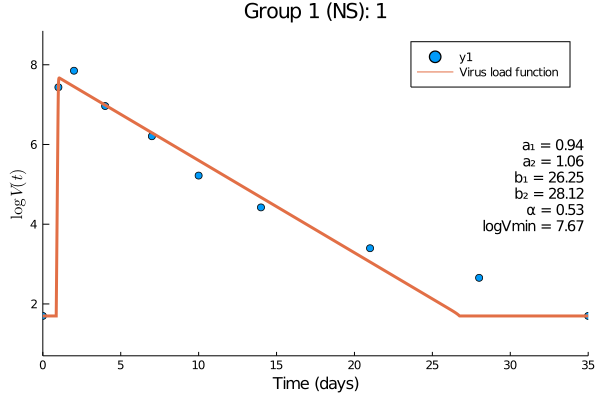


Data: Group 1 (NS), Monkey no.: 1
RSS = 1.40722e+00 (convergence: true)
  a₁ = 9.373e-01 (initial=9.647e-01)
  a₂ = 1.056e+00 (initial=1.114e+00)
  b₁ = 2.625e+01 (initial=2.625e+01)
  b₂ = 2.812e+01 (initial=2.812e+01)
  α = 5.331e-01 (initial=8.000e-01)
  logVmin = 7.670e+00 (initial=7.800e+00)

Data: 

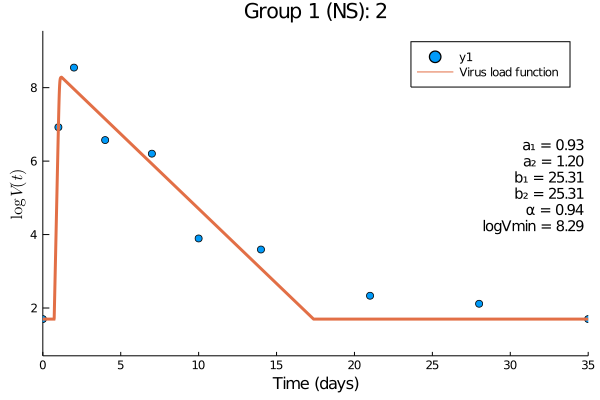

Group 1 (NS), Monkey no.: 2
RSS = 2.24921e+00 (convergence: true)
  a₁ = 9.348e-01 (initial=2.587e-01)
  a₂ = 1.204e+00 (initial=1.637e+00)
  b₁ = 2.531e+01 (initial=1.740e+01)
  b₂ = 2.531e+01 (initial=3.322e+01)
  α = 9.378e-01 (initial=8.000e-01)
  logVmin = 8.285e+00 (initial=7.800e+00)


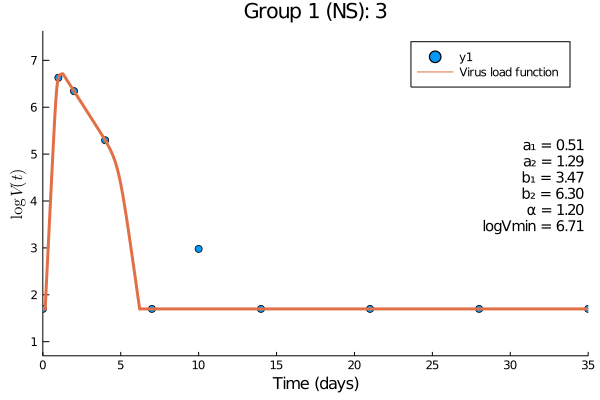


Data: Group 1 (NS), Monkey no.: 3
RSS = 1.63562e+00 (convergence: true)
  a₁ = 5.088e-01 (initial=2.979e-01)
  a₂ = 1.290e+00 (initial=1.944e+00)
  b₁ = 3.469e+00 (initial=3.890e+00)
  b₂ = 6.295e+00 (initial=6.627e+00)
  α = 1.195e+00 (initial=8.000e-01)
  logVmin = 6.712e+00 (initial=7.800e+00)

Data: 

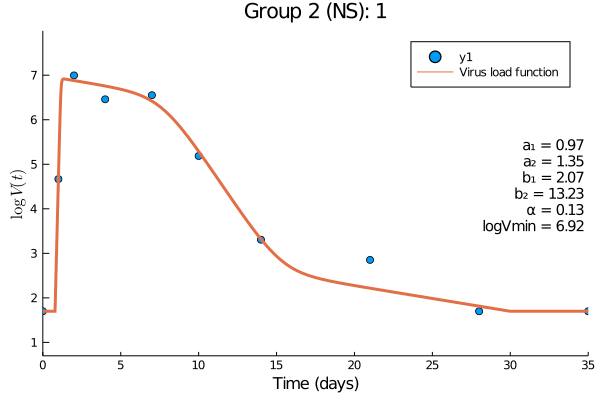

Group 2 (NS), Monkey no.: 1
RSS = 5.48007e-01 (convergence: false)
  a₁ = 9.742e-01 (CI=(-2.108e+09, 2.108e+09), initial=6.248e-01)
  a₂ = 1.350e+00 (CI=(-2.697e+10, 2.697e+10), initial=2.062e+00)
  b₁ = 2.072e+00 (CI=(-2.429e+00, 6.573e+00), initial=2.082e+00)
  b₂ = 1.323e+01 (CI=(9.747e+00, 1.670e+01), initial=2.437e+01)
  α = 1.324e-01 (CI=(-2.114e-01, 4.761e-01), initial=8.000e-01)
  logVmin = 6.918e+00 (CI=(-1.551e+09, 1.551e+09), initial=7.800e+00)


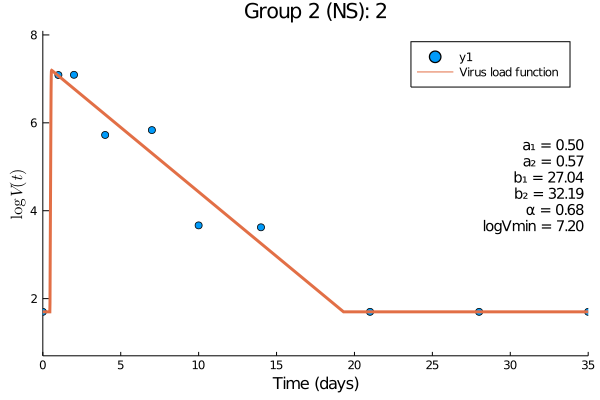


Data: Group 2 (NS), Monkey no.: 2
RSS = 1.30971e+00 (convergence: true)
  a₁ = 4.976e-01 (initial=4.976e-01)
  a₂ = 5.705e-01 (initial=5.717e-01)
  b₁ = 2.704e+01 (initial=2.470e+01)
  b₂ = 3.219e+01 (initial=3.336e+01)
  α = 6.758e-01 (initial=8.000e-01)
  logVmin = 7.196e+00 (initial=7.800e+00)

Data: 

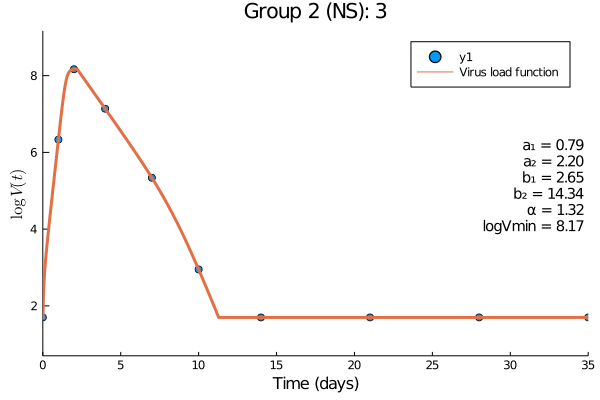

Group 2 (NS), Monkey no.: 3
RSS = 0.00000e+00 (convergence: true)
  a₁ = 7.912e-01 (CI=(7.912e-01, 7.912e-01), initial=1.639e+00)
  a₂ = 2.201e+00 (CI=(2.201e+00, 2.201e+00), initial=2.422e+00)
  b₁ = 2.645e+00 (CI=(2.645e+00, 2.645e+00), initial=2.868e+00)
  b₂ = 1.434e+01 (CI=(1.434e+01, 1.434e+01), initial=5.922e+00)
  α = 1.319e+00 (CI=(1.319e+00, 1.319e+00), initial=8.000e-01)
  logVmin = 8.174e+00 (CI=(8.174e+00, 8.174e+00), initial=7.800e+00)


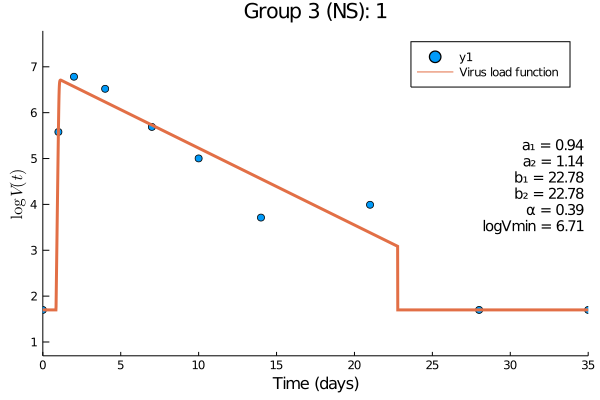


Data: Group 3 (NS), Monkey no.: 1
RSS = 1.26373e+00 (convergence: true)
  a₁ = 9.412e-01 (initial=8.594e-01)
  a₂ = 1.144e+00 (initial=1.172e+00)
  b₁ = 2.278e+01 (initial=1.177e+01)
  b₂ = 2.278e+01 (initial=3.378e+01)
  α = 3.861e-01 (initial=8.000e-01)
  logVmin = 6.712e+00 (initial=7.800e+00)

Data: 

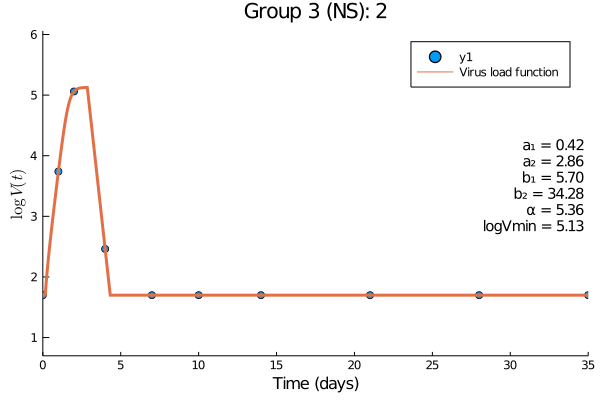

Group 3 (NS), Monkey no.: 2
RSS = 0.00000e+00 (convergence: true)
  a₁ = 4.213e-01 (initial=7.266e-01)
  a₂ = 2.855e+00 (initial=4.984e+00)
  b₁ = 5.704e+00 (initial=6.414e+00)
  b₂ = 3.428e+01 (initial=1.143e+01)
  α = 5.362e+00 (initial=8.000e-01)
  logVmin = 5.127e+00 (initial=7.800e+00)


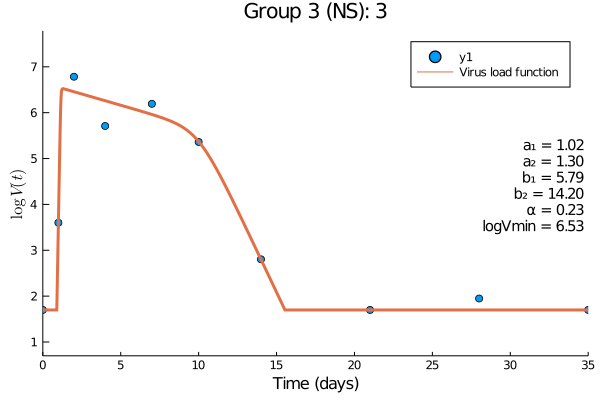


Data: Group 3 (NS), Monkey no.: 3
RSS = 5.26524e-01 (convergence: true)
  a₁ = 1.017e+00 (CI=(-6.771e+10, 6.771e+10), initial=1.774e-01)
  a₂ = 1.296e+00 (CI=(-1.283e+12, 1.283e+12), initial=1.873e+00)
  b₁ = 5.794e+00 (CI=(-4.319e+02, 4.435e+02), initial=2.514e+00)
  b₂ = 1.420e+01 (CI=(-4.828e+01, 7.669e+01), initial=2.317e+01)
  α = 2.254e-01 (CI=(-1.475e+00, 1.926e+00), initial=8.000e-01)
  logVmin = 6.525e+00 (CI=(-1.256e+11, 1.256e+11), initial=7.800e+00)


In [6]:
for dataname in ["Group 1 (NS)", "Group 2 (NS)", "Group 3 (NS)"]
    for monkey in [1, 2, 3]
        ttdata = parse.(Float64, names(RAWDATA[dataname]))
        vvdata = Array(RAWDATA[dataname])[monkey, :]
        data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
        resultVLF = nothing
        for iter = 1:10000
            #       a₁,   a₂,   b₁,   b₂,           α,    logVmax
            par0 = vcat(sort(data.t[end]*rand(4)), [0.80, 7.8])
            result = try 
                VirusLoadCurve.fitVLF(data, par0)
            catch y
                nothing
            end
            if result != nothing
                if resultVLF == nothing
                    resultVLF = result
                else
                    if sum(abs2, result.fit.resid) < sum(abs2, resultVLF.fit.resid)
                        resultVLF = result
                    end
                end
            end
        end
        println("\nData: ", dataname, ", Monkey no.: ", monkey)
        summary(resultVLF)
        pt = plot(data)
        plot!(pt, resultVLF)
        title!(pt, dataname*": "*string(monkey))
        val = ""
        for i in 1:length(resultVLF.fit.param)
            val *= @sprintf "%s = %.2f \n" resultVLF.names[i] resultVLF.fit.param[i]
        end
        annotate!((ttdata[end], (maximum(vvdata)+minimum(vvdata))/2, text(val, 10, :right, :middle)))
        savefig(figdir*"Chandrashekar2020"*dataname*string(monkey)*".png")
        display(pt)
    end
end